In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os, sys
import matplotlib as mpl
import pandas as pd
import itertools

from astropy import units as u
from astropy.coordinates import Angle

import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser

from astropy.io import fits

from scipy.stats import rayleigh,beta,gamma,uniform

# Define function to generate simulated atm params according to their prob. distributions 

In [2]:
def simul_params(param,n,a,b,loc,scale):
    ""
    low = loc-scale
    high = loc+scale
    #sim_param = uniform.rvs(loc=loc,scale=scale,size=n)
    sim_param = np.random.uniform(low=low,high=high,size=n)
        
    return sim_param

# Set parameters for simulation 

In [3]:
#Number of simulated parameters of each type 
nsim = 10000
atm_params = ['pwv','aerosol','ozone','cloud','airmass']
dist_params = {'pwv':{'a':3,'b':7,'loc':3.0,'scale':3.0},
               'aerosol':{'a':None,'b':None,'loc':0.04,'scale':0.03},
               'ozone':{'a':3,'b':3,'loc':300,'scale':100},
               'cloud':{'a':0.5,'b':1.5,'loc':0.5,'scale':0.5},
               'airmass':{'a':2,'b':3,'loc':1,'scale':2},
}
index_params = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}
nparams = len(atm_params)

In [4]:
sim_dict = {}
for p in atm_params:
    a = dist_params[p]['a']
    b = dist_params[p]['b']
    loc = dist_params[p]['loc']
    scale = dist_params[p]['scale']
    param = simul_params(p,nsim,a,b,loc,scale)
    sim_dict[p] = param

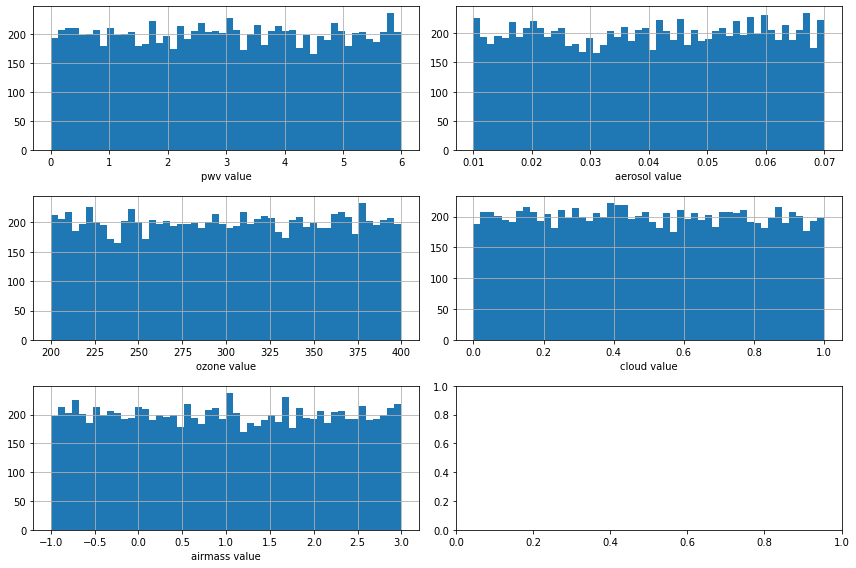

In [5]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(12,8))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(atm_params):
            atm_param_ = atm_params[i]
            i += 1
            
            axs[row,col].hist(sim_dict[atm_param_],bins=50)
            axs[row,col].set_xlabel('{0} value'.format(atm_param_))
            axs[row,col].grid()
        
plt.tight_layout()

# Fix the other parameters (we will vary only one) 

In [6]:
#aer0 = np.mean(sim_dict['aerosol'])
#oz0 = np.mean(sim_dict['ozone'])
aer0 = dist_params['aerosol']['loc']
oz0 = dist_params['ozone']['loc']

#cloud0 = np.mean(sim_dict['cloud'])
#am0 = np.mean(sim_dict['airmass'])
am0 = 1.2
pressure = 0.0
clouds = 0.0
print('Aerosols - Ozone - Clouds - Airmass - Pressure')
print(aer0,'-',oz0,'-',clouds,'-',am0,'-',pressure)

Aerosols - Ozone - Clouds - Airmass - Pressure
0.04 - 300 - 0.0 - 1.2 - 0.0


# Simulate atm transparencies from the PWV simulated values 

In [9]:
sys.path.append('libradtran')
print(sys.path)

['/home/martin/auxtel_lsst/github/my_photomCorrectAuxtel/AuxTel_atm_photo_corr', '/home/martin/anaconda3/lib/python39.zip', '/home/martin/anaconda3/lib/python3.9', '/home/martin/anaconda3/lib/python3.9/lib-dynload', '', '/home/martin/anaconda3/lib/python3.9/site-packages', '/home/martin/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg', '/home/martin/anaconda3/lib/python3.9/site-packages/pysynphot-2.0.0-py3.9-linux-x86_64.egg', '/home/martin/anaconda3/lib/python3.9/site-packages/emcee-3.1.1-py3.9.egg', '/home/martin/anaconda3/lib/python3.9/site-packages/astroquery-0.4.5-py3.9.egg', '/home/martin/anaconda3/lib/python3.9/site-packages/docopt-0.6.2-py3.9.egg', '/home/martin/anaconda3/lib/python3.9/site-packages/pyvo-1.2.1-py3.9.egg', '/home/martin/anaconda3/lib/python3.9/site-packages/pytz-2021.3-py3.9.egg', '/home/martin/anaconda3/lib/python3.9/site-packages/urllib3-1.26.8-py3.9.egg', '/home/martin/anaconda3/lib/python3.9/site-packages/libradtranpy-0.1.0-py3.9.egg', '/home

In [10]:
import libsimulateVisible

In [11]:
#Example with one PWV value, to see that everything works 
path,thefile=libsimulateVisible.ProcessSimulationaer(am0,np.mean(sim_dict['pwv']),oz0,aer0,pressure,prof_str='us',proc_str='as',cloudext=clouds)

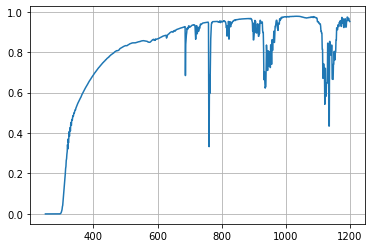

In [12]:
transp0 = np.loadtxt(os.path.join(path,thefile))
l = transp0[:,0]
t = transp0[:,1]

plt.plot(l,t)
plt.grid()

In [13]:
nwl = len(l)
print(nwl)

951


# Check that the wavelenghts are the same 

In [16]:
path2,thefile2=libsimulateVisible.ProcessSimulationaer(am0,np.mean(sim_dict['pwv']),oz0,aer0,pressure,prof_str='us',proc_str='as',cloudext=0)
transp02 = np.loadtxt(os.path.join(path2,thefile2))
wl = transp02[:,0]
print((wl==l).all())
wl_ref = wl

True


# Simulate atm transparencies for all simulated values of the selected parameter 

In [17]:
variable_param = 'aerosol'
fixed_params = {}
for param in atm_params:
    if param != variable_param:
        fixed_params[param] = np.mean(sim_dict[param])
        fixed_params[param] = dist_params[param]['loc']
    if param == 'airmass':
        fixed_params[param] = 1.2
    if param == 'cloud':
        fixed_params[param] = clouds

In [18]:
n_transp = 50

In [19]:
fixed_params

{'pwv': 3.0, 'ozone': 300, 'cloud': 0.0, 'airmass': 1.2}

In [20]:
dataout = np.zeros((n_transp+1,nwl+nparams))
dataout[0,nparams:] = wl_ref
for isim in range(1,n_transp+1):
    print(isim)
    for param in atm_params:
        if param != variable_param:
            dataout[isim,index_params[param]] = fixed_params[param]
        else:
            dataout[isim,index_params[param]] = sim_dict[param][isim]
    airmass_ = dataout[isim,index_params['airmass']]
    pwv_ = dataout[isim,index_params['pwv']]
    ozone_ = dataout[isim,index_params['ozone']]
    aerosol_ = dataout[isim,index_params['aerosol']]
    cloud_ = dataout[isim,index_params['cloud']]
    #Run libradtran 
    path,thefile=libsimulateVisible.ProcessSimulationaer(airmass_,pwv_,ozone_,aerosol_,pressure,prof_str='us',proc_str='as',cloudext=cloud_)
    transp_file = np.loadtxt(os.path.join(path,thefile))
    
    t = transp_file[:,1]
    dataout[isim,nparams:] = t

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [21]:
hdr = fits.Header()
hdr['NTRANSP']=n_transp
#hdr['ID_NUM']=idx_out_num
hdr['ID_AM']=index_params['airmass']
hdr['ID_VAOD']=index_params['aerosol']
hdr['ID_PWV']=index_params['pwv']
hdr['ID_O3']=index_params['ozone']
hdr['ID_CLD']=index_params['cloud']
hdr['ID_RES']=nparams

output_dir = './simulated_transparencies'
if os.path.exists(output_dir) == False:
    os.mkdir(output_dir)
output_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)

output_fullfilename = os.path.join(output_dir,output_file)

hdu = fits.PrimaryHDU(dataout,header=hdr)
hdu.writeto(output_fullfilename,overwrite=True)